<a href="https://colab.research.google.com/github/ChengyangHuang/Personalized_Regression/blob/main/Disease_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os

if not os.path.exists("/content/hcvdat0.csv"):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

from scipy.spatial import KDTree
from scipy.spatial import distance_matrix
from scipy.special import softmax, expit

import torch

# np.random.seed(0)


def load_dataset(impute=True, binary=True):
    dataset = pd.read_csv("/content/hcvdat0.csv", usecols=range(1, 14))
    print(dataset)
    X = []
    sex_dict = {'m': 0,
                'f': 1}
    for name, data in dataset.items():
        if name == "Category":
            y = data.to_list()
            y = [x.split('=')[0] for x in y]
            y = np.array([int(x) if x.isdigit() else 5 for x in y])
            if binary:
                y = np.array([0 if x == 0 or x == 5 else 1 for x in y])
        elif name == "Sex":
            X.append([int(sex_dict[x]) for x in data])
        else:
            X.append([float(x) for x in data])

    X = np.array(X).T
    if impute == True:
        imputer = KNNImputer(n_neighbors=2)
        X = imputer.fit_transform(X)
    return X, y


def plot_parameters(theta_gt, theta_est):
    fig, ax = plt.subplots(1)
    ax.scatter(theta_gt[:, 0], theta_gt[:, 1], label="True Parameters")
    ax.scatter(theta_est[:, 0], theta_est[:, 1], label="EST. Parameters")
    ax.legend()
    return fig, ax


def print_metrics(dic):
    message = f"\n"
    for k, v in dic.items():
        message += f"{k}:\t{v}\n"
    print(message)


def evaluate_method(method, X_test, y_test, method_name, U_test=None):
    if method_name == "Linear Regression" or method_name == "Gaussian Mixture":
        pred = method.predict(X_test)
        y_pred = (pred>0.5)*1
        # y_prob = expit(pred).reshape((-1, 1))
        y_prob = np.clip(pred, 0, 1).reshape((-1, 1))
        y_prob = np.concatenate((1-y_prob, y_prob), axis=1)
    elif method_name == "Personalized Regression":
        y_pred = method.predict(X_test, U_test)
        y_prob = method.predict_proba(X_test, U_test)
    else:
        y_pred = method.predict(X_test)
        y_prob = method.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_prob[:, 1])
    performance_dict = {"method_name": method_name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "fscore": fscore,
                        "auroc": auroc}
    return performance_dict

In [34]:
class PRBinaryClassifier():
    def __init__(self, args, theta_pop, trainset, validset=None):
        # Training Parameters
        self.cov_norm_ord = args.covariate_norm_ord
        self.cov_xstart = args.covariate_x_start
        self.cov_xend= args.covariate_x_end
        self.sigma_theta = args.sigma_theta
        self.lambd = args.theta_regularizer
        self.gamma = args.distance_regularizer
        self.nu = args.phi_regularizer
        self.alpha = args.learning_rate
        self.c = args.lr_decay
        self.q = args.latent_dim
        self.k = args.covariate_dim
        self.log_steps = args.log_steps
        self.n_neighbors = args.n_neighbors
        self.show_logs = args.show_logs
        self.use_distance_loss = args.use_distance_loss

        self.theta_pop = torch.from_numpy(theta_pop)
        self.p = self.theta_pop.shape[0]

        # Training Data
        X_train, y_train, U_train = trainset
        self.X_train = torch.from_numpy(X_train)
        self.y_train = torch.from_numpy(y_train).to(dtype=torch.double)
        self.__init_U_train(U_train)
        self.n = self.X_train.shape[0]

        # Validation Data
        if type(validset) != "NoneType":
            self.eval = True
            self.X_eval, self.y_eval, self.U_eval = validset
        else: 
            self.eval = False

        # Variable Initialization
        PI = np.random.multivariate_normal(theta_pop, self.sigma_theta*np.eye(self.p), size=self.n)
        self.PI = torch.from_numpy(PI)
        self.Z, self.Q = self.__init_ZnQ(PI)
        self.phi = torch.ones((self.k, ), dtype=torch.float64) / self.k

        # Loss Functions
        self.__sample_specific_loss = torch.nn.BCELoss(reduction="sum")
        self.__parameter_regularizer = torch.nn.L1Loss()
        self.__phi_regularizer = torch.nn.MSELoss()
        self.__distance_loss = torch.nn.MSELoss()


    def train(self, n_epoch=5):
        for epoch in range(n_epoch):
            # Require Gradient for variables
            Z = self.Z.clone().requires_grad_(True)
            Q = self.Q.clone().requires_grad_(True)
            phi = self.phi.clone().requires_grad_(True)
            PI = self.__update_PI(Z, Q) 

            y_prob = self.__predict_proba(self.X_train, PI)

            # Calculate Loss
            l_loss = self.__sample_specific_loss(y_prob, self.y_train)
            if self.use_distance_loss:
                D_loss = self.__distance_matching_regularizer(Z, phi)
            else:
                D_loss = 0  
            theta_loss = self.__parameter_regularizer(PI, torch.zeros_like(PI))
            phi_sum = torch.sum(phi, dim=0, keepdim=True)
            phi_loss = self.__phi_regularizer(phi_sum, torch.ones_like(phi_sum)) # Weight should sum to one
            loss = l_loss + self.gamma * D_loss + self.lambd * theta_loss + self.nu * phi_loss
            
            # Update phi
            loss.backward()
            self.phi -= self.alpha * phi.grad

            # Update Z
            alpha_cust = self.alpha / torch.linalg.norm(self.PI-self.theta_pop, 
                                                        float('inf'), dim=1, keepdim=True)

            # self.Z -= alpha_cust * Z.grad
            self.Z -= torch.bmm(Z.grad.unsqueeze(2), alpha_cust.unsqueeze(2)).squeeze()

            # Update Q
            self.Q -= self.alpha * Q.grad

            # Update alpha
            self.alpha *= self.c

            # Update theta, PI
            self.PI = self.__update_PI(self.Z, self.Q)

            if self.show_logs and epoch % self.log_steps == 0:
                message = f"Epoch {epoch+1} - Total loss: {loss}\tDistance loss:{D_loss}"
                print("-"*20)
                print(message)
                if self.eval:
                    print_metrics(evaluate_method(self, self.X_eval, self.y_eval, "Personalized Regression", self.U_eval))
                print("-"*20)
        

    def predict(self, X_test, U_test):
        y_prob = self.predict_proba(X_test, U_test)
        y_pred = y_prob.argmax(axis=1)
        return y_pred


    def predict_proba(self, X_test, U_test):
        X = torch.from_numpy(X_test)
        dist_mat_test = self.__create_distance_matrix(self.U_train.numpy(), U_test)
        _, idx_sets = torch.matmul(dist_mat_test, self.phi).topk(self.n_neighbors, dim=1)
        PI = self.PI[idx_sets, :].mean(axis=1)
        prob = self.__predict_proba(X, PI).detach().numpy().reshape((-1, 1))
        y_prob = np.concatenate((1-prob, prob), axis=1)
        return y_prob


    def __predict_proba(self, X, PI):
        prob = torch.bmm(X.unsqueeze(1), PI.unsqueeze(2)).squeeze()
        prob = torch.sigmoid(prob)
        return prob

    def __create_distance_matrix(self, A, B):
        dist_mat = []
        for i in range(self.k):
            dist_mat.append(distance_matrix(A[:, [i]], B[:, [i]], p=self.cov_norm_ord))
        dist_mat = torch.from_numpy(np.array(dist_mat)).T
        return dist_mat

    def __init_U_train(self, U_train: np.array):
        self.U_train = torch.from_numpy(U_train)
        self.U_distance_mat = self.__create_distance_matrix(U_train, U_train)
        # print(f"Distance Matrix Shape: {self.U_distance_mat.shape}")


    def __init_ZnQ(self, PI):
        pca = PCA(n_components=self.q, whiten=False)
        Z = pca.fit_transform(PI)
        Q = pca.components_
        return torch.from_numpy(Z), torch.from_numpy(Q)
    

    def __update_PI(self, Z, Q):
        return torch.mm(Z, Q) + self.theta_pop
    

    def __distance_matching_regularizer(self, Z, phi):       
        _Z = Z.detach().numpy()
        tree = KDTree(_Z)
        _, idx_set = tree.query(_Z, k=6)
        idx_set = idx_set[:, 1:]
        Z_set = Z[idx_set, :]
        delta_Z = Z.view(Z.shape[0], 1, -1).expand(-1, Z_set.shape[1], -1) - Z_set
        delta_Z = torch.linalg.norm(delta_Z, ord=2, dim=2)

        U_dist_idx = torch.from_numpy(idx_set).to(dtype=torch.int64).view(idx_set.shape[0], -1, 1).expand(-1, -1, self.k)
        U_dist_set = torch.gather(self.U_distance_mat, 1, U_dist_idx)
        rho_U = torch.matmul(U_dist_set, phi)
        d_loss = self.__distance_loss(delta_Z, rho_U)
        return d_loss


          Category  Age Sex   ALB    ALP  ...    CHE  CHOL   CREA    GGT  PROT
0    0=Blood Donor   32   m  38.5   52.5  ...   6.93  3.23  106.0   12.1  69.0
1    0=Blood Donor   32   m  38.5   70.3  ...  11.17  4.80   74.0   15.6  76.5
2    0=Blood Donor   32   m  46.9   74.7  ...   8.84  5.20   86.0   33.2  79.3
3    0=Blood Donor   32   m  43.2   52.0  ...   7.33  4.74   80.0   33.8  75.7
4    0=Blood Donor   32   m  39.2   74.1  ...   9.15  4.32   76.0   29.9  68.7
..             ...  ...  ..   ...    ...  ...    ...   ...    ...    ...   ...
610    3=Cirrhosis   62   f  32.0  416.6  ...   5.57  6.30   55.7  650.9  68.5
611    3=Cirrhosis   64   f  24.0  102.8  ...   1.54  3.02   63.0   35.9  71.3
612    3=Cirrhosis   64   f  29.0   87.3  ...   1.66  3.63   66.7   64.2  82.0
613    3=Cirrhosis   46   f  33.0    NaN  ...   3.56  4.20   52.0   50.0  71.0
614    3=Cirrhosis   59   f  36.0    NaN  ...   9.07  5.30   67.0   34.0  68.0

[615 rows x 13 columns]


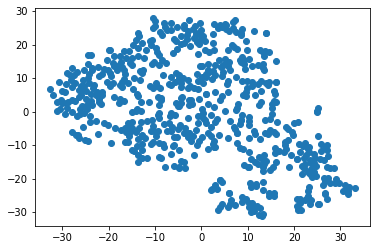

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--------------------
Epoch 1 - Total loss: 36.25347940915487	Distance loss:0

method_name:	Personalized Regression
accuracy:	0.9064039408866995
precision:	[0.90909091 0.875     ]
recall:	[0.98837209 0.4516129 ]
fscore:	[0.94707521 0.59574468]
auroc:	0.9711177794448612

--------------------
--------------------
Epoch 101 - Total loss: 14.258074737681785	Distance loss:0

method_name:	Personalized Regression
accuracy:	0.9113300492610837
precision:	[0.91397849 0.88235294]
recall:	[0.98837209 0.48387097]
fscore:	[0.94972067 0.625     ]
auroc:	0.9720555138784697

--------------------
--------------------
Epoch 201 - Total loss: 7.439181838889004	Distance loss:0

method_name:	Personalized Regression
accuracy:	0.916256157635468
precision:	[0.91891892 0.88888889]
recall:	[0.98837209 0.51612903]
fscore:	[0.95238095 0.65306122]
auroc:	0.9720555138784697

--------------------
--------------------
Epoch 301 - Total loss: 3.8594876193719934	Distance loss:0

method_name:	Personalized Regression
accur

In [35]:
class PR_Arguments():
    # Data Arguments
    sigma_theta = 0.001
    theta_regularizer = 0.01
    distance_regularizer = 0.01
    phi_regularizer = 1

    # 
    n_neighbors = 3
    latent_dim = 2
    covariate_dim = 2
    covariate_norm_ord = 2
    covariate_x_start = 2
    covariate_x_end = -1

    # Traing Arguments
    learning_rate = 4e-3
    lr_decay = 1-1e-4
    n_epoch = 2000 #2000
    log_steps = 100
    show_logs = True
    use_distance_loss = False


def main():
    X, y = load_dataset()
    U = TSNE().fit_transform(X[:, 2:])
    plt.scatter(U[:, 0], U[:, 1])
    plt.show()
    X_train, X_test, y_train, y_test, U_train, U_test = train_test_split(X, y, U, test_size=0.33, random_state=42)

    ## Preprocessing
    scaler =  StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ### Methods
    dict_list = []

    ## Linear Regression
    lr = LinearRegression().fit(X_train, y_train)
    dict_lr = evaluate_method(lr, X_test, y_test, "Linear Regression")
    dict_list.append(dict_lr)

    ## Gaussian Mixture
    gmm = GaussianMixture(n_components=3).fit(X_train, y_train)
    dict_gmm = evaluate_method(gmm, X_test, y_test, "Gaussian Mixture")
    dict_list.append(dict_gmm)

    ## DNN
    dnn = MLPClassifier(hidden_layer_sizes=(50,)).fit(X_train, y_train.squeeze())
    dict_dnn = evaluate_method(dnn, X_test, y_test, "Deep Neural Networks")
    dict_list.append(dict_dnn)

    ## Logistic Regression
    lor = LogisticRegression().fit(X_train, y_train)
    dict_lor = evaluate_method(lor, X_test, y_test, "Logistic Regression")
    dict_list.append(dict_lor)

    ## Personalized Regression
    pr_args = PR_Arguments()
    theta_lor = np.concatenate((np.array(lor.coef_).T, np.array(lor.intercept_).reshape((-1, 1))), axis=0)
    X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
    X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
    trainset = (X_train, y_train, U_train)
    evalset = (X_test, y_test, U_test)
    pr = PRBinaryClassifier(pr_args, theta_lor.squeeze(), trainset, evalset)
    pr.train(pr_args.n_epoch)
    dict_pr = evaluate_method(pr, X_test, y_test, "Personalized Regression", U_test)
    dict_list.append(dict_pr) 

    for x in dict_list:
        print_metrics(x)


if __name__ == "__main__":
    main()